In [8]:
# ==========================================
# Basic Machine Learning Setup for XGBoost Models
# ==========================================

# Import core libraries
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Import scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import PartialDependenceDisplay

# Import advanced gradient boosting frameworks
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")


In [9]:
# Load dataset
df = pd.read_csv("electrode_data.csv")
df.head()


,Pos_D,Neg_D,Pos_var,Neg_var,Capacity,Stability
0,-10.29423,-10.30980,0.36592,0.27136,224.2,0.75
1,-10.29423,-10.88714,0.36592,0.22075,265.4,0.82
2,-10.29423,-11.26269,0.36592,0.65550,18.4,0.55
3,-10.29423,-10.43430,0.36592,0.25055,65.6,0.70
4,-10.29423,-11.29965,0.36592,0.60348,68.5,0.31


In [10]:
# Feature engineering
X = df[['Pos_D', 'Neg_D', 'Pos_var', 'Neg_var']].copy()
X['D_ratio'] = df['Pos_D'] / df['Neg_D']
X['var_sum'] = df['Pos_var'] + df['Neg_var']
X['overlap_index'] = np.minimum(df['Pos_D'], df['Neg_D']) / np.maximum(df['Pos_D'], df['Neg_D'])

mu_pos = df['Pos_D']
mu_neg = df['Neg_D']
sigma_pos = np.sqrt(df['Pos_var'].clip(lower=0))
sigma_neg = np.sqrt(df['Neg_var'].clip(lower=0))

X['CSI'] = (np.abs(mu_pos - mu_neg) + 2 * np.abs(sigma_pos - sigma_neg)) / (sigma_pos + sigma_neg)
X['WDD'] = (mu_pos * sigma_pos - mu_neg * sigma_neg) / (mu_pos + mu_neg)
X['AI'] = (sigma_pos - sigma_neg) / (sigma_pos + sigma_neg)
X['D_ratio_CSI'] = X['D_ratio'] * X['CSI']


# Target variable: Stability
y = df['Stability']


In [11]:
# Data split and normalization
from sklearn.preprocessing import StandardScaler
X = X.dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



XGBoost R²: 0.8856146494900283
RMSE: 0.06718225427054851


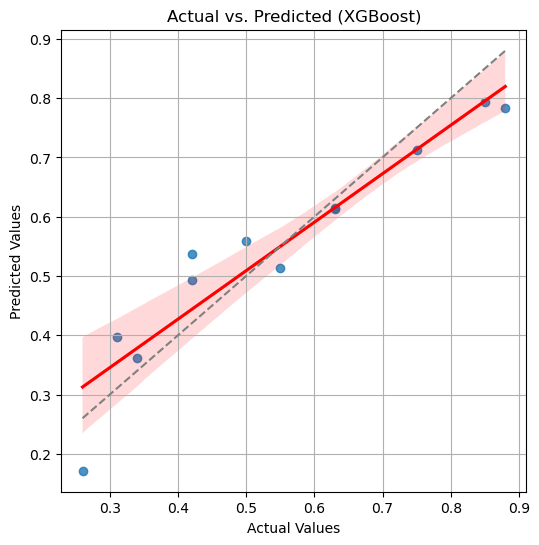

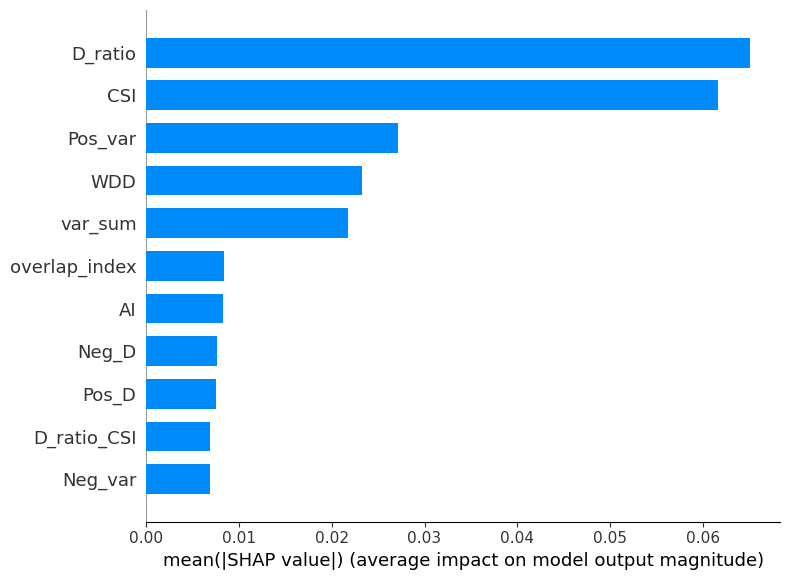

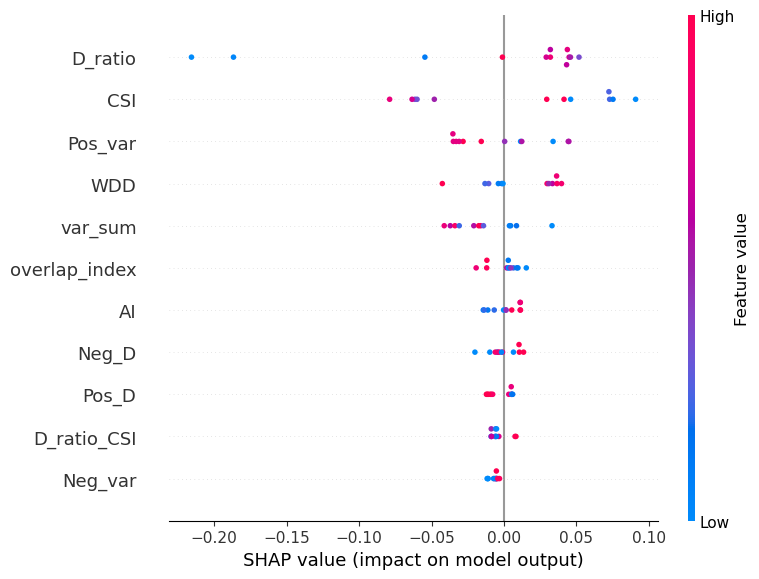

In [12]:
# ==========================================
# Train XGBoost regression model
# ==========================================
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

xgb = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42, verbosity=0)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

# Model evaluation
print("XGBoost R²:", r2_score(y_test, xgb_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, xgb_preds)))

plt.figure(figsize=(6,6))
sns.regplot(x=y_test, y=xgb_preds, line_kws={'color':'red'})
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted (XGBoost)")
plt.grid(True)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='gray')
plt.savefig("actual_vs_predicted.jpg", dpi=300)  
plt.show()

# ==========================================
# SHAP analysis
# ==========================================
explainer_xgb = shap.Explainer(xgb, X_train)
shap_values_xgb = explainer_xgb(X_test)

shap.summary_plot(shap_values_xgb, X_test, plot_type="bar")
shap.summary_plot(shap_values_xgb, X_test)

# --- SHAP bar plot ---
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar", show=False)
ax = plt.gca()

# Add black frame
for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_linewidth(1.0)  
    ax.spines[spine].set_color("black")  

plt.savefig("shap_summary_bar.jpg", dpi=300, bbox_inches='tight')
plt.close()



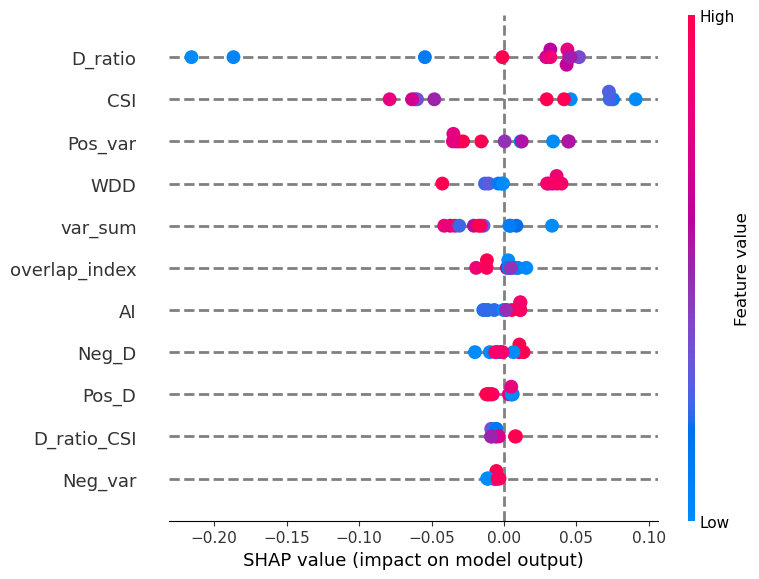

In [13]:
import matplotlib.pyplot as plt

# --- SHAP dot plot ---
shap.summary_plot(shap_values_xgb, X_test, show=False)
ax = plt.gca()

for coll in ax.collections:
    coll.set_sizes([100] * coll.get_offsets().shape[0])  # dot size

# line
for line in ax.lines:
    line.set_linewidth(2)
    line.set_linestyle('--')
    line.set_color('grey')

plt.savefig("shap_summary_dot_bold.jpg", dpi=300, bbox_inches='tight')
plt.show()


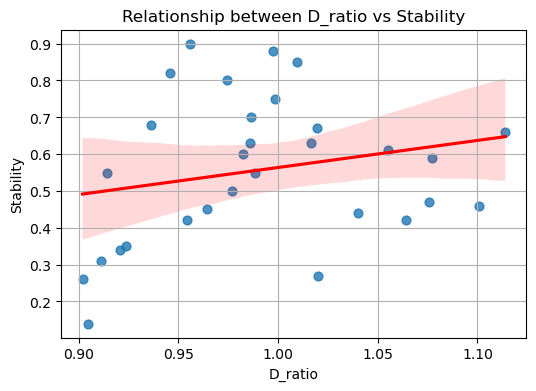

In [14]:
# ==========================================
# Feature-Performance Relationship and Distribution Analysis
# ==========================================

# --- Scatter plot: D_ratio vs Stability ---
plt.figure(figsize=(6,4))
sns.regplot(x=X['D_ratio'], y=y, scatter_kws={'s':40}, line_kws={'color':'red'})
plt.xlabel("D_ratio")
plt.ylabel("Stability")
plt.title("Relationship between D_ratio vs Stability")
plt.grid(True)
plt.show()


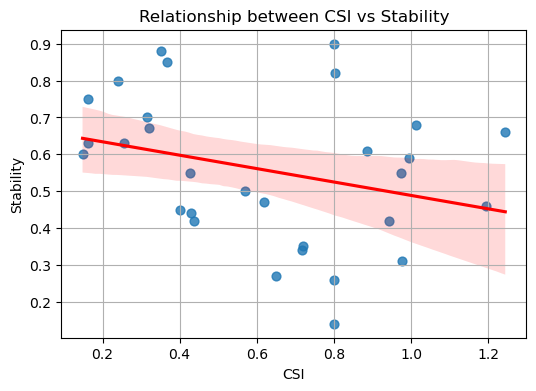

In [15]:
# --- Scatter plot: CSI vs Stability ---
plt.figure(figsize=(6,4))
sns.regplot(x=X['CSI'], y=y, scatter_kws={'s':40}, line_kws={'color':'red'})
plt.xlabel("CSI")
plt.ylabel("Stability")
plt.title("Relationship between CSI vs Stability")
plt.grid(True)
plt.show()


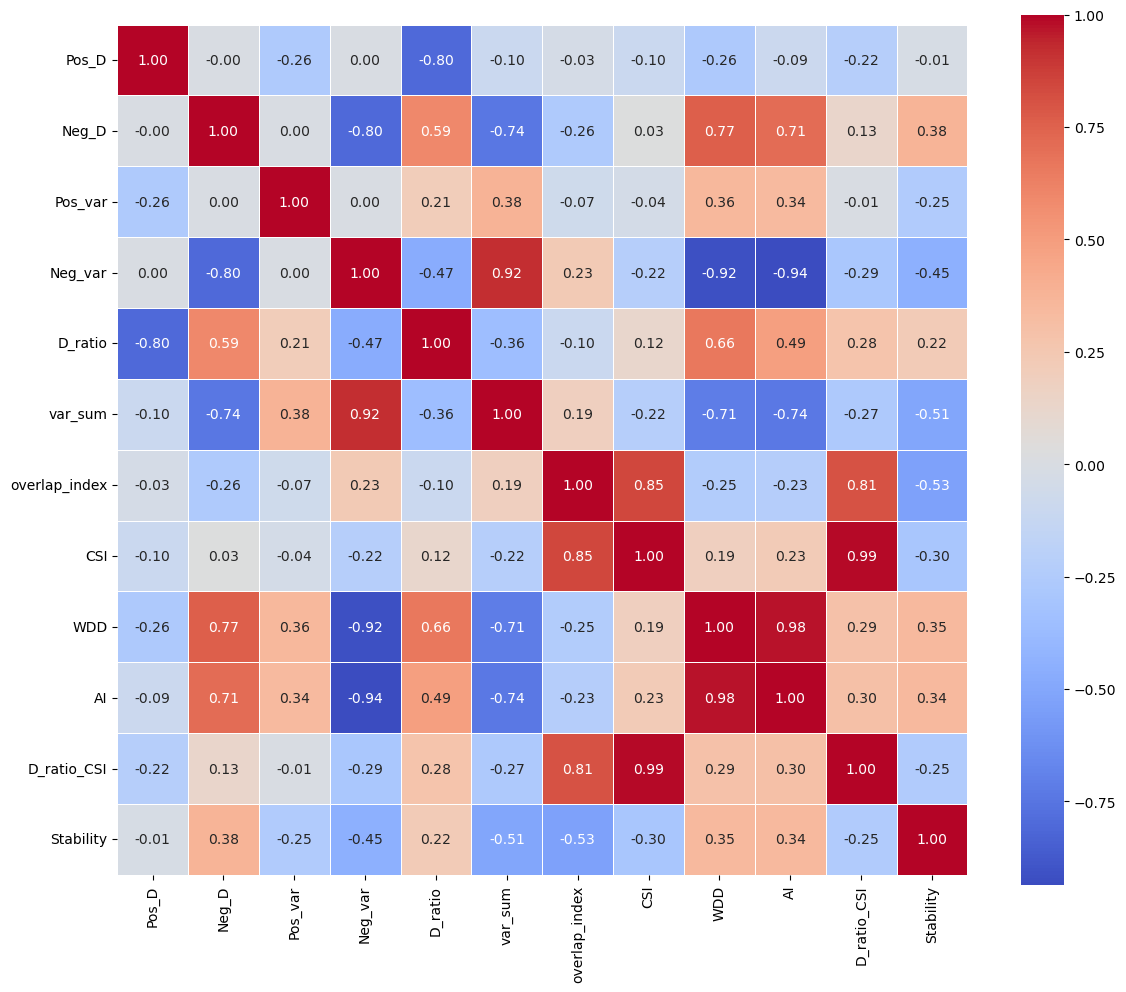

In [16]:
# --- Correlation heatmap ---

plt.figure(figsize=(12, 10))

corr_matrix = X.copy()
corr_matrix['Stability'] = y
corr = corr_matrix.corr()

sns.heatmap(corr, 
            annot=True, 
            cmap='coolwarm', 
            linewidths=0.5, 
            fmt=".2f", 
            square=True, 
            cbar=True)

plt.tight_layout()
plt.savefig("related.jpg", dpi=300)  
plt.show()


✅ High Stability Region (Top 30% predicted):
 - D_ratio range: 0.936 ~ 1.020
 - CSI range: 0.241 ~ 1.013


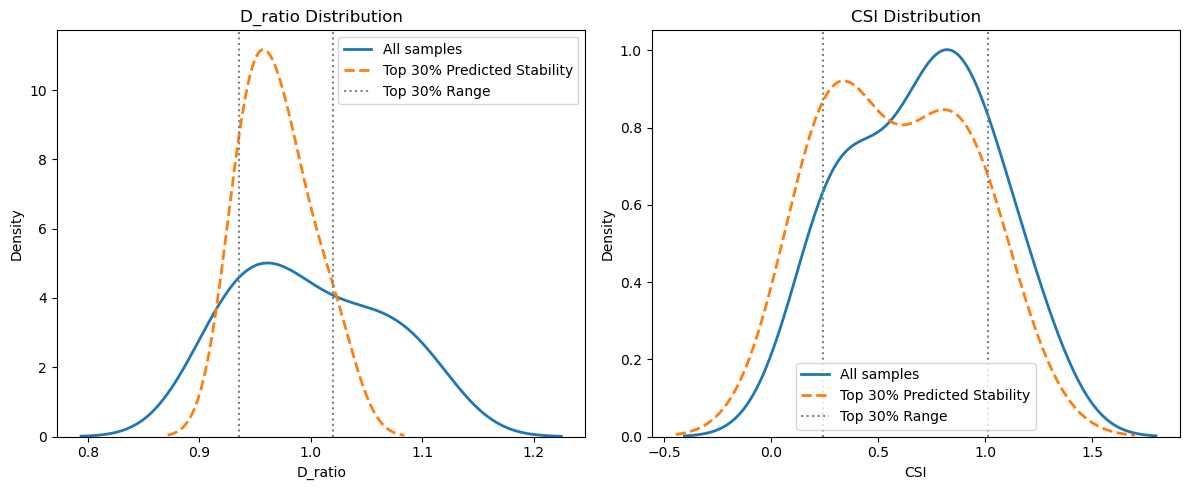

In [17]:
# ==========================================
# High-Performance Region Analysis: Top 30%
# ==========================================

train_preds = xgb.predict(X_train)
df_pred = X_train.copy()
df_pred['Predicted_Stability'] = train_preds

threshold = np.percentile(train_preds, 70)
high_perf = df_pred[df_pred['Predicted_Stability'] >= threshold]

d_min, d_max = high_perf['D_ratio'].min(), high_perf['D_ratio'].max()
c_min, c_max = high_perf['CSI'].min(), high_perf['CSI'].max()

print("✅ High Stability Region (Top 30% predicted):")
print(f" - D_ratio range: {d_min:.3f} ~ {d_max:.3f}")
print(f" - CSI range: {c_min:.3f} ~ {c_max:.3f}")
plt.figure(figsize=(12, 5))

# D_ratio distribution
plt.subplot(1, 2, 1)
sns.kdeplot(X_train['D_ratio'], label='All samples', linewidth=2)
sns.kdeplot(high_perf['D_ratio'], label='Top 30% Predicted Stability', linewidth=2, linestyle='--')
plt.axvline(d_min, color='gray', linestyle=':', label='Top 30% Range')
plt.axvline(d_max, color='gray', linestyle=':')
plt.xlabel("D_ratio")
plt.title("D_ratio Distribution")
plt.legend()

# CSI distribution
plt.subplot(1, 2, 2)
sns.kdeplot(X_train['CSI'], label='All samples', linewidth=2)
sns.kdeplot(high_perf['CSI'], label='Top 30% Predicted Stability', linewidth=2, linestyle='--')
plt.axvline(c_min, color='gray', linestyle=':', label='Top 30% Range')
plt.axvline(c_max, color='gray', linestyle=':')
plt.xlabel("CSI")
plt.title("CSI Distribution")
plt.legend()

plt.tight_layout()
plt.savefig("D_CSI_high_stability_distribution-top30%.jpg", dpi=300)
plt.show()


✅ High Stability Region (Top 10% predicted):
 - D_ratio range: 0.946 ~ 0.956
 - CSI range: 0.801 ~ 0.803


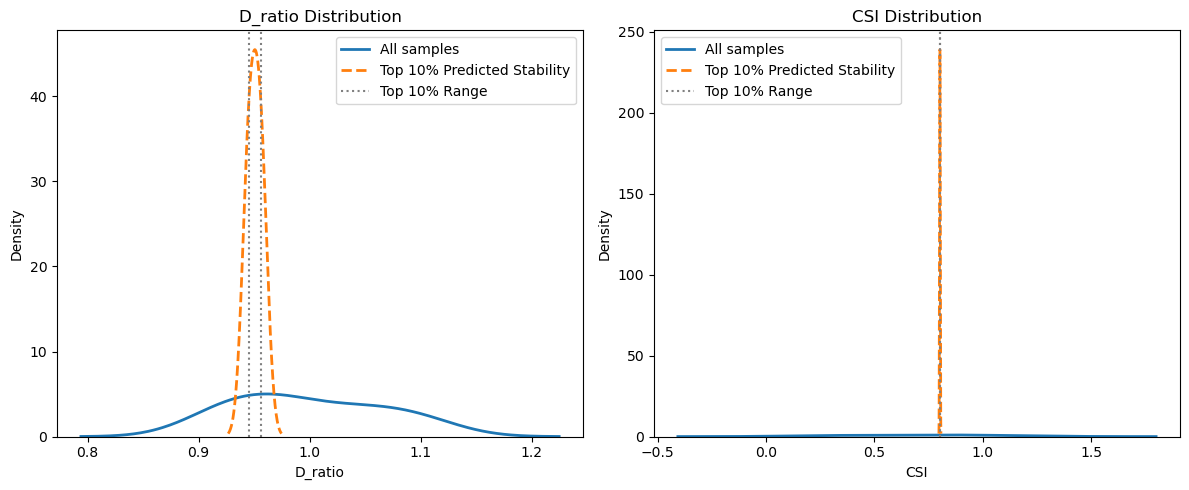

In [18]:
# ==========================================
# Top 10%  regions 
# ==========================================

train_preds = xgb.predict(X_train)
df_pred = X_train.copy()
df_pred['Predicted_Stability'] = train_preds
threshold = np.percentile(train_preds, 90)
high_perf = df_pred[df_pred['Predicted_Stability'] >= threshold]

d_min, d_max = high_perf['D_ratio'].min(), high_perf['D_ratio'].max()
c_min, c_max = high_perf['CSI'].min(), high_perf['CSI'].max()

print("✅ High Stability Region (Top 10% predicted):")
print(f" - D_ratio range: {d_min:.3f} ~ {d_max:.3f}")
print(f" - CSI range: {c_min:.3f} ~ {c_max:.3f}")
plt.figure(figsize=(12, 5))

# D_ratio distribution
plt.subplot(1, 2, 1)
sns.kdeplot(X_train['D_ratio'], label='All samples', linewidth=2)
sns.kdeplot(high_perf['D_ratio'], label='Top 10% Predicted Stability', linewidth=2, linestyle='--')
plt.axvline(d_min, color='gray', linestyle=':', label='Top 10% Range')
plt.axvline(d_max, color='gray', linestyle=':')
plt.xlabel("D_ratio")
plt.title("D_ratio Distribution")
plt.legend()

# CSI distribution
plt.subplot(1, 2, 2)
sns.kdeplot(X_train['CSI'], label='All samples', linewidth=2)
sns.kdeplot(high_perf['CSI'], label='Top 10% Predicted Stability', linewidth=2, linestyle='--')
plt.axvline(c_min, color='gray', linestyle=':', label='Top 10% Range')
plt.axvline(c_max, color='gray', linestyle=':')
plt.xlabel("CSI")
plt.title("CSI Distribution")
plt.legend()

plt.tight_layout()
plt.savefig("D_CSI_high_stability_distribution-top10%.jpg", dpi=300)
plt.show()


In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ===============================
# D_ratio KDE
# ===============================
kde_all_d = sns.kdeplot(X_train['D_ratio'], bw_adjust=1).get_lines()[0].get_data()
plt.close()

kde_top_d = sns.kdeplot(high_perf['D_ratio'], bw_adjust=1).get_lines()[0].get_data()
plt.close()

# ===============================
# CSI KDE
# ===============================
kde_all_c = sns.kdeplot(X_train['CSI'], bw_adjust=1).get_lines()[0].get_data()
plt.close()

kde_top_c = sns.kdeplot(high_perf['CSI'], bw_adjust=1).get_lines()[0].get_data()
plt.close()

# ===============================
# save DataFrame
# ===============================
kde_df = pd.DataFrame({
    "D_ratio_all_x": kde_all_d[0],
    "D_ratio_all_density": kde_all_d[1],
    "D_ratio_top_x": kde_top_d[0],
    "D_ratio_top_density": kde_top_d[1],
    "CSI_all_x": kde_all_c[0],
    "CSI_all_density": kde_all_c[1],
    "CSI_top_x": kde_top_c[0],
    "CSI_top_density": kde_top_c[1],
})

kde_df.to_csv("D_CSI_density_TOP10.txt", sep="\t", index=False)


✅ High Stability Region (Top 10% predicted):
 - - D_ratio range: 0.936 ~ 1.114
 - CSI range: 0.148 ~ 1.244


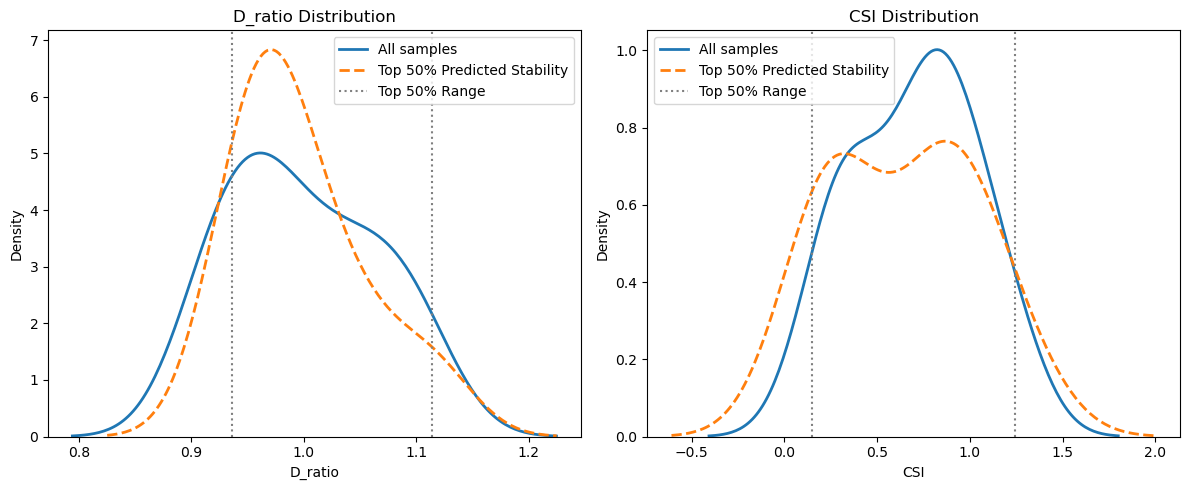

In [20]:
# ==========================================
# Top 50%  regions 
# ==========================================

train_preds = xgb.predict(X_train)
df_pred = X_train.copy()
df_pred['Predicted_Stability'] = train_preds
threshold = np.percentile(train_preds, 50)
high_perf = df_pred[df_pred['Predicted_Stability'] >= threshold]

d_min, d_max = high_perf['D_ratio'].min(), high_perf['D_ratio'].max()
c_min, c_max = high_perf['CSI'].min(), high_perf['CSI'].max()

print("✅ High Stability Region (Top 10% predicted):")
print(f" - - D_ratio range: {d_min:.3f} ~ {d_max:.3f}")
print(f" - CSI range: {c_min:.3f} ~ {c_max:.3f}")

plt.figure(figsize=(12, 5))

# D_ratio distribution
plt.subplot(1, 2, 1)
sns.kdeplot(X_train['D_ratio'], label='All samples', linewidth=2)
sns.kdeplot(high_perf['D_ratio'], label='Top 50% Predicted Stability', linewidth=2, linestyle='--')
plt.axvline(d_min, color='gray', linestyle=':', label='Top 50% Range')
plt.axvline(d_max, color='gray', linestyle=':')
plt.xlabel("D_ratio")
plt.title("D_ratio Distribution")
plt.legend()

# CSI distribution
plt.subplot(1, 2, 2)
sns.kdeplot(X_train['CSI'], label='All samples', linewidth=2)
sns.kdeplot(high_perf['CSI'], label='Top 50% Predicted Stability', linewidth=2, linestyle='--')
plt.axvline(c_min, color='gray', linestyle=':', label='Top 50% Range')
plt.axvline(c_max, color='gray', linestyle=':')
plt.xlabel("CSI")
plt.title("CSI Distribution")
plt.legend()

plt.tight_layout()
plt.savefig("D_CSI_high_stability_distribution-top50%.jpg", dpi=300)
plt.show()

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ===============================
# D_ratio KDE
# ===============================
kde_all_d = sns.kdeplot(X_train['D_ratio'], bw_adjust=1).get_lines()[0].get_data()
plt.close()

kde_top_d = sns.kdeplot(high_perf['D_ratio'], bw_adjust=1).get_lines()[0].get_data()
plt.close()

# ===============================
# CSI KDE
# ===============================
kde_all_c = sns.kdeplot(X_train['CSI'], bw_adjust=1).get_lines()[0].get_data()
plt.close()

kde_top_c = sns.kdeplot(high_perf['CSI'], bw_adjust=1).get_lines()[0].get_data()
plt.close()

# ===============================
# save DataFrame
# ===============================
kde_df = pd.DataFrame({
    "D_ratio_all_x": kde_all_d[0],
    "D_ratio_all_density": kde_all_d[1],
    "D_ratio_top_x": kde_top_d[0],
    "D_ratio_top_density": kde_top_d[1],
    "CSI_all_x": kde_all_c[0],
    "CSI_all_density": kde_all_c[1],
    "CSI_top_x": kde_top_c[0],
    "CSI_top_density": kde_top_c[1],
})

kde_df.to_csv("D_CSI_density_TOP50.txt", sep="\t", index=False)

In [22]:
# ==========================================
# Export full prediction data (for plotting or supplementary)
# ==========================================

results_df = pd.DataFrame({
    "Stability_true": y_test,
    "Stability_pred": xgb_preds,
    "D_ratio": X_test['D_ratio'].values,
    "CSI": X_test['CSI'].values
})

results_sorted = results_df.sort_values(by="Stability_pred", ascending=False)

# Top10%、Top30%、Top50%
top10_cut = int(len(results_sorted) * 0.10)
top30_cut = int(len(results_sorted) * 0.30)
top50_cut = int(len(results_sorted) * 0.50)

high_perf_10 = results_sorted.iloc[:top10_cut]
high_perf = results_sorted.iloc[:top30_cut]     # high_perf（Top30%）
high_perf_50 = results_sorted.iloc[:top50_cut]
